In [20]:
import sys
sys.path.append("../")
import pandas as pd
from utils.data_utils import DataLoader
import xgboost as xgb
import optuna
import lightgbm as lgb
from importlib import reload
from sklearn.metrics import roc_auc_score, accuracy_score
import json
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from utils import visualization
from utils.encoding import Encoded_Features, CatEncoderWrapper
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report
import seaborn as sns

reload(visualization)
reload(sys.modules['utils.data_utils'])
reload(sys.modules['utils.encoding'])

<module 'utils.encoding' from '/home/azeem/Documents/ML-I/ML1-XAI/Project/notebooks/../utils/encoding.py'>

In [3]:
data_loader = DataLoader(file_path='../data/raw/Churn_Modelling.xls' , target_column='Exited', test_size=0.2, random_state=42, clean_data=True)

In [4]:
X, y = data_loader.get_data()
X_enc, y_enc = data_loader.get_data_enc()

In [5]:
X_train, y_train = data_loader.get_train_data()
X_test, y_test = data_loader.get_test_data()

X_train_enc, y_train_enc = data_loader.get_train_data_enc()
X_test_enc, y_test_enc = data_loader.get_test_data_enc()

In [6]:
print(X.shape, y.shape)
print(X_enc.shape, y_enc.shape, '\n')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape, '\n')

print(X_train_enc.shape, y_train_enc.shape)
print(X_test_enc.shape, y_test_enc.shape, '\n')

(9867, 10) (9867,)
(9867, 13) (9867,) 

(7893, 10) (7893,)
(1974, 10) (1974,) 

(7893, 13) (7893,)
(1974, 13) (1974,) 



Class ditribution in training data
        count      %
Exited              
0        6272  79.46
1        1621  20.54


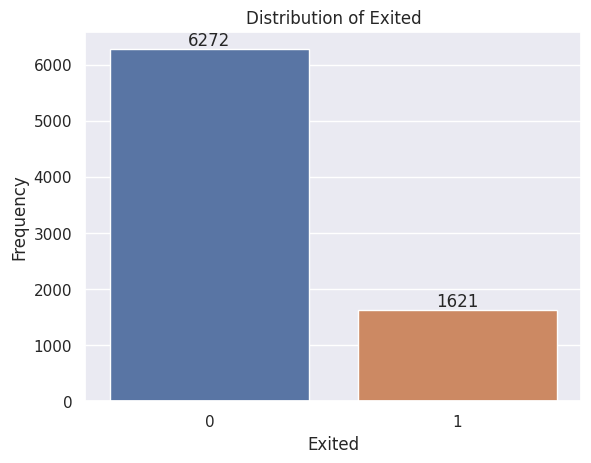

In [7]:
print('Class ditribution in training data')

c = y_train.value_counts()
p = y_train.value_counts(normalize=True).mul(100).round(2)
train_dist = pd.concat([c, p], axis = 1, keys=['count', '%'])

print(train_dist)

print('='*50)

visualization.plot_count(y_train)

Class ditribution in testing data
        count      %
Exited              
0        1569  79.48
1         405  20.52


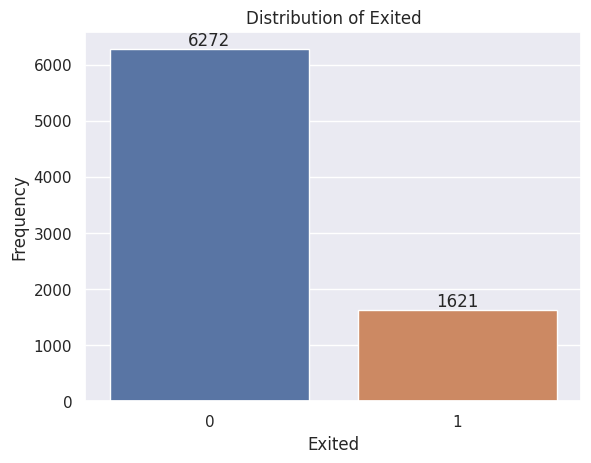

In [8]:
print('Class ditribution in testing data')

c = y_test.value_counts()
p = y_test.value_counts(normalize=True).mul(100).round(2)
test_dist = pd.concat([c, p], axis = 1, keys=['count', '%'])

print(test_dist)

print('='*50)

visualization.plot_count(y_train)

# Hyperparameter Tuning

Following algorithms are used with both Ordinal & One-Hot Encoding

- XGBoost
- LGBM
- Random Forest
- CatBoost
- Neural Network (MLPClassifier)

## XGBoost

In [36]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = X_train_enc, X_test_enc, y_train_enc, y_test_enc

def objective(trial):
    # Define the hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    n_estimators = trial.suggest_int('n_estimators', 50, 1500)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-7, 1e-2, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-7, 1e-2, log=True)
    gamma = trial.suggest_float('gamma', 1e-7, 1e-2, log=True)
    max_delta_step = trial.suggest_int('max_delta_step', 0, 10)

    # Initialize the model with the hyperparameters
    model = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                              min_child_weight=min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree,
                              reg_alpha=reg_alpha, reg_lambda=reg_lambda, gamma=gamma, max_delta_step=max_delta_step,
                              random_state=42)

    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Predict the probabilities on the validation set
    y_proba = model.predict_proba(X_val)[:, 1]

    # Calculate the AUC-ROC score
    score = roc_auc_score(y_val, y_proba)
    
    return score

# Set up the Optuna study
# study = optuna.create_study(
#     direction='maximize',
#     storage="sqlite:///hyperparameter_tune.sqlite3",
#     study_name="xgboost"
# )

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and score
print(f'Best hyperparameters: {study.best_params}')
print(f'Best score: {study.best_value}')

[I 2023-05-28 03:12:50,039] A new study created in RDB with name: xgboost
[I 2023-05-28 03:13:06,338] Trial 0 finished with value: 0.8585715522193109 and parameters: {'learning_rate': 0.0033562049659401623, 'n_estimators': 1201, 'max_depth': 19, 'min_child_weight': 8, 'subsample': 0.15579415573173813, 'colsample_bytree': 0.8802314313955335, 'reg_alpha': 7.77819036031226e-05, 'reg_lambda': 1.140997834806272e-07, 'gamma': 1.7538333735243716e-07, 'max_delta_step': 8}. Best is trial 0 with value: 0.8585715522193109.
[I 2023-05-28 03:13:15,400] Trial 1 finished with value: 0.8555413922526733 and parameters: {'learning_rate': 7.396731551715647e-05, 'n_estimators': 454, 'max_depth': 20, 'min_child_weight': 5, 'subsample': 0.342160496928111, 'colsample_bytree': 0.43670171897776755, 'reg_alpha': 8.15747614203605e-05, 'reg_lambda': 0.00015939547855738212, 'gamma': 0.009084656743858742, 'max_delta_step': 3}. Best is trial 0 with value: 0.8585715522193109.
[I 2023-05-28 03:13:35,223] Trial 2 finis

Best hyperparameters: {'colsample_bytree': 0.7805321430674614, 'gamma': 9.22150090710089e-07, 'learning_rate': 0.00032626568841185466, 'max_delta_step': 7, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 1278, 'reg_alpha': 6.891656173957401e-06, 'reg_lambda': 2.650164335053026e-06, 'subsample': 0.5646417874574408}
Best score: 0.8642494629747658


Train model with complete data using best parameters

In [37]:
with open("../models/XGBoost/best_param_xgboost.json", "w") as json_file:
    json.dump(study.best_params, json_file)

model = xgb.XGBClassifier(**study.best_params)
model.fit(X_enc, y)

joblib.dump(model, '../models/XGBoost/model_xgboost.sav')

['../models/XGBoost/model_xgboost.sav']

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1569
           1       0.86      0.50      0.64       405

    accuracy                           0.88      1974
   macro avg       0.87      0.74      0.78      1974
weighted avg       0.88      0.88      0.87      1974



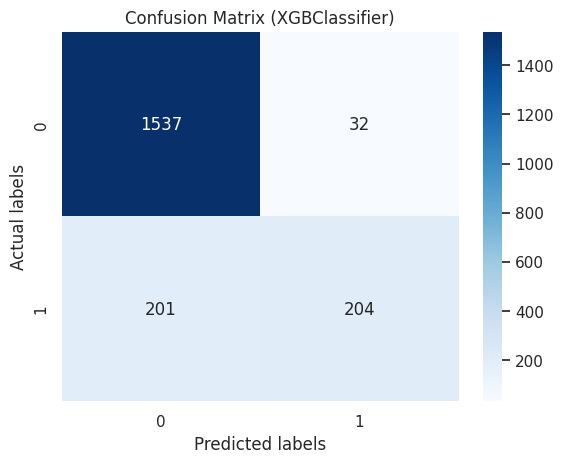

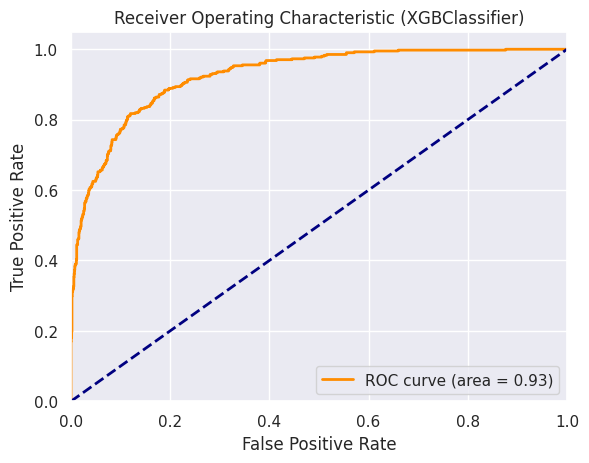

In [105]:
model = joblib.load('../models/XGBoost/model_xgboost.sav')
visualization.plot_roc(model, X_test_enc, y_test_enc, 'XGBClassifier')

## LGBM

In [39]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = X_train_enc, X_test_enc, y_train, y_test

def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'objective': 'binary',
        'metric': 'logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-7, 1e-2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-7, 1e-2, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-7, 1e-2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500)
    }

    # Initialize the model with the hyperparameters
    model = lgb.LGBMClassifier(**params, random_state=42)

    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Predict the probabilities on the validation set
    y_proba = model.predict_proba(X_val)[:, 1]

    # Calculate the AUC-ROC score
    score = roc_auc_score(y_val, y_proba)
    
    return score
# Set up the Optuna study
# study = optuna.create_study(
#     direction='maximize',
#     storage="sqlite:///hyperparameter_tune.sqlite3",
#     study_name="lgbm"
#     )

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and score
print(f'Best hyperparameters: {study.best_params}')
print(f'Best score: {study.best_value}')

[I 2023-05-28 03:54:04,161] A new study created in RDB with name: lgbm
[I 2023-05-28 03:54:14,713] Trial 0 finished with value: 0.8584755564997758 and parameters: {'learning_rate': 3.216341870889859e-05, 'num_leaves': 140, 'max_depth': 18, 'min_child_samples': 18, 'subsample': 0.4374103953832126, 'colsample_bytree': 0.8616180398809146, 'reg_alpha': 0.008473569545760496, 'reg_lambda': 1.5239746189091861e-07, 'min_split_gain': 0.001579083304692222, 'n_estimators': 856}. Best is trial 0 with value: 0.8584755564997758.
[I 2023-05-28 03:54:21,843] Trial 1 finished with value: 0.8510476909882051 and parameters: {'learning_rate': 2.6653883398640603e-05, 'num_leaves': 33, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.2756050133782564, 'colsample_bytree': 0.20082668572218498, 'reg_alpha': 7.90625769372073e-06, 'reg_lambda': 1.8610025962420428e-06, 'min_split_gain': 0.00010211400751973183, 'n_estimators': 1367}. Best is trial 0 with value: 0.8584755564997758.
[I 2023-05-28 03:54:27,329]

Best hyperparameters: {'colsample_bytree': 0.6221448791609003, 'learning_rate': 0.004027692869235329, 'max_depth': 5, 'min_child_samples': 8, 'min_split_gain': 2.1455705887868852e-05, 'n_estimators': 1387, 'num_leaves': 191, 'reg_alpha': 1.2599135550273806e-07, 'reg_lambda': 2.5119865876035366e-05, 'subsample': 0.969262823190842}
Best score: 0.8670899920528135


Train model with complete data using best parameters

In [40]:
with open("../models/LGBM/best_param_enc.json", "w") as json_file:
    json.dump(study.best_params, json_file)
    
model = lgb.LGBMClassifier(**study.best_params)
model.fit(X_enc, y)

joblib.dump(model, '../models/LGBM/model_lgbm.sav')

['../models/LGBM/model_lgbm.sav']

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1569
           1       0.82      0.53      0.64       405

    accuracy                           0.88      1974
   macro avg       0.86      0.75      0.78      1974
weighted avg       0.87      0.88      0.87      1974



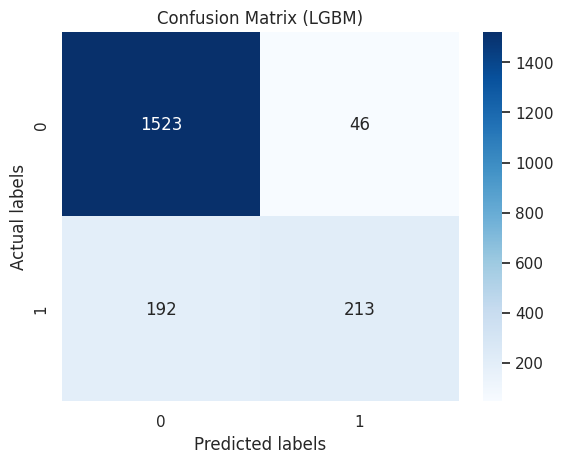

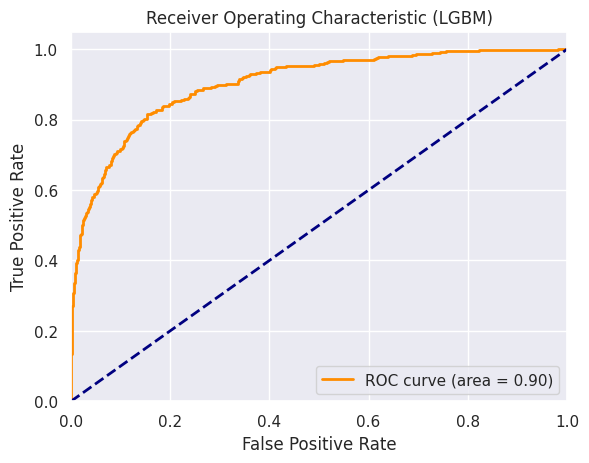

In [104]:
model = joblib.load('../models/LGBM/model_lgbm.sav')
visualization.plot_roc(model, X_test_enc, y_test_enc, 'LGBM')

## Random Forest

In [41]:
X_train, X_val, y_train, y_val = X_train_enc, X_test_enc, y_train, y_test

def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 50, 1500)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2', None])
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced", "balanced_subsample"])

    # Initialize the model with the hyperparameters
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                   max_features=max_features, criterion=criterion, bootstrap=bootstrap,
                                   class_weight=class_weight, random_state=42)

    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Predict the probabilities on the validation set
    y_proba = model.predict_proba(X_val)[: ,1]

    # Calculate the AUC-ROC score
    score = roc_auc_score(y_val, y_proba)

    # Return the negative AUC-ROC score, as Optuna minimizes the objective function
    return score

# Define the study object and optimize the objective function
# study = optuna.create_study(direction='maximize',
#     storage="sqlite:///hyperparameter_tune.sqlite3",
#     study_name="rf")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and score
print(f"Best hyperparameters: {study.best_params}")
print(f"Best auc_roc: {study.best_value}")

[I 2023-05-28 04:05:16,374] A new study created in RDB with name: rf
[I 2023-05-28 04:05:22,489] Trial 0 finished with value: 0.8586927271439699 and parameters: {'n_estimators': 424, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'log2', 'criterion': 'gini', 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.8586927271439699.
[I 2023-05-28 04:05:36,734] Trial 1 finished with value: 0.8557089913367797 and parameters: {'n_estimators': 1443, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'log2', 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8586927271439699.
[I 2023-05-28 04:05:45,652] Trial 2 finished with value: 0.8092856187396233 and parameters: {'n_estimators': 427, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'criterion': 'entropy', 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 0 w

Best hyperparameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 753}
Best auc_roc: 0.8640197027280094


Train model with complete data using best parameters

In [42]:
with open("../models/Random_Forest/best_param_enc.json", "w") as json_file:
    json.dump(study.best_params, json_file)
    
model = RandomForestClassifier(**study.best_params)
model.fit(X_enc, y)

joblib.dump(model, '../models/Random_Forest/model_rf.sav')

['../models/Random_Forest/model_rf.sav']

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1569
           1       0.88      0.50      0.64       405

    accuracy                           0.88      1974
   macro avg       0.88      0.74      0.78      1974
weighted avg       0.88      0.88      0.87      1974



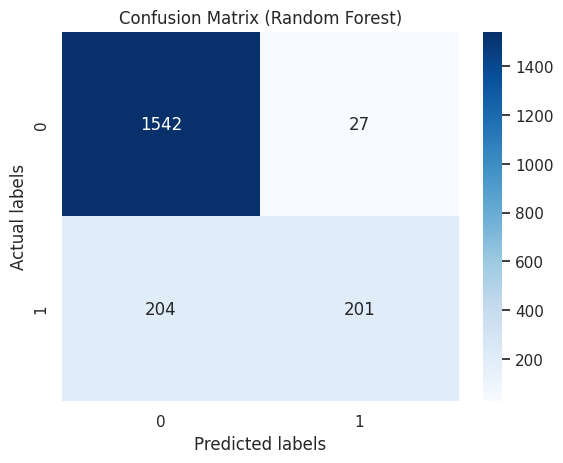

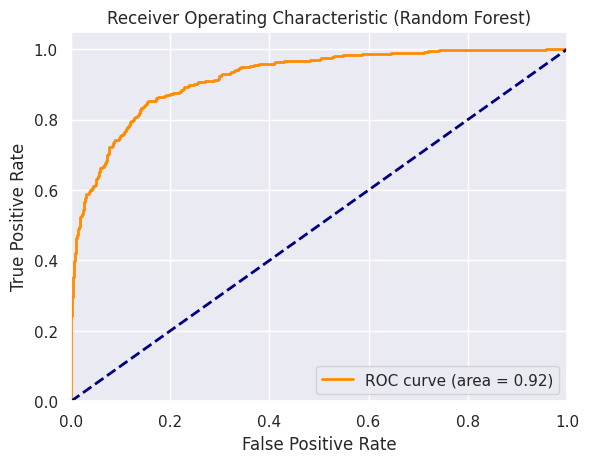

In [103]:
model = joblib.load('../models/Random_Forest/model_rf.sav')
visualization.plot_roc(model, X_test_enc, y_test_enc, 'Random Forest')

In [45]:
col_list = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

## CatBoost

In [52]:
X_train, y_train = data_loader.get_train_data()
X_test, y_test = data_loader.get_test_data()

categorical_features = [1, 2, 4, 6, 7, 8]

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = X_train, X_test, y_train, y_test

def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'depth': trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-7, 1e-2, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
        'thread_count': 2,  # set the number of CPU threads to use
        'random_state': 42
    }

    # Initialize the Pool object for the training and validation data
    train_pool = Pool(X_train, y_train, cat_features=categorical_features)
    val_pool = Pool(X_val, y_val, cat_features=categorical_features)

    # Initialize the model with the hyperparameters
    model = CatBoostClassifier(**params)

    # Train the model on the training set
    model.fit(train_pool, eval_set=val_pool, verbose=False)

    # Predict the probabilities on the validation set
    y_proba = model.predict_proba(val_pool)[:, 1]

    # Calculate the AUC-ROC score
    score = roc_auc_score(y_val, y_proba)
    
    return score

# Set up the Optuna study
# study = optuna.create_study(direction='maximize',
#     storage="sqlite:///hyperparameter_tune.sqlite3",
#     study_name="catboost")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and score
print(f'Best hyperparameters: {study.best_params}')
print(f'Best score: {study.best_value}')


[I 2023-05-28 09:13:48,781] A new study created in RDB with name: catboost
[I 2023-05-28 09:13:54,139] Trial 0 finished with value: 0.837772741936753 and parameters: {'learning_rate': 2.4969953044777917e-05, 'iterations': 403, 'depth': 3, 'l2_leaf_reg': 0.001813969151277835, 'border_count': 147, 'colsample_bylevel': 0.8631475809385806, 'subsample': 0.3260596087895886, 'scale_pos_weight': 0.35950859183477457, 'bagging_temperature': 2.01881237211626, 'random_strength': 1.8802473953718912}. Best is trial 0 with value: 0.837772741936753.
[I 2023-05-28 09:14:01,286] Trial 1 finished with value: 0.8392764125927499 and parameters: {'learning_rate': 0.0003594847228937223, 'iterations': 650, 'depth': 9, 'l2_leaf_reg': 2.6827383295178126e-07, 'border_count': 179, 'colsample_bylevel': 0.14670244129947446, 'subsample': 0.7908370486899917, 'scale_pos_weight': 8.710511480511993, 'bagging_temperature': 4.911258096775243, 'random_strength': 6.877629314400374}. Best is trial 1 with value: 0.83927641259

Best hyperparameters: {'bagging_temperature': 2.886104679378868, 'border_count': 27, 'colsample_bylevel': 0.943923094290858, 'depth': 6, 'iterations': 957, 'l2_leaf_reg': 1.1031301980383066e-07, 'learning_rate': 0.0413601369009607, 'random_strength': 1.053295848775364, 'scale_pos_weight': 1.502179562409839, 'subsample': 0.31835245782533167}
Best score: 0.8691452446710572


In [55]:
with open("../models/CatBoost/best_param_enc.json", "w") as json_file:
    json.dump(study.best_params, json_file)
    
categorical_features = [1, 2, 4, 6, 7, 8]
train_pool = Pool(X, y, cat_features=categorical_features)
model = CatBoostClassifier(**study.best_params)
model.fit(train_pool)

joblib.dump(model, '../models/CatBoost/model_cb.sav')

0:	learn: 0.6648723	total: 18.2ms	remaining: 17.4s
1:	learn: 0.6360561	total: 28.1ms	remaining: 13.4s
2:	learn: 0.6152313	total: 40.1ms	remaining: 12.8s
3:	learn: 0.5941263	total: 54.9ms	remaining: 13.1s
4:	learn: 0.5783093	total: 67.2ms	remaining: 12.8s
5:	learn: 0.5594854	total: 77.8ms	remaining: 12.3s
6:	learn: 0.5450338	total: 90.6ms	remaining: 12.3s
7:	learn: 0.5327798	total: 106ms	remaining: 12.6s
8:	learn: 0.5191862	total: 142ms	remaining: 15s
9:	learn: 0.5061383	total: 165ms	remaining: 15.6s
10:	learn: 0.4954179	total: 181ms	remaining: 15.6s
11:	learn: 0.4867766	total: 218ms	remaining: 17.2s
12:	learn: 0.4786890	total: 240ms	remaining: 17.4s
13:	learn: 0.4702973	total: 275ms	remaining: 18.5s
14:	learn: 0.4640022	total: 295ms	remaining: 18.5s
15:	learn: 0.4591061	total: 309ms	remaining: 18.2s
16:	learn: 0.4542413	total: 321ms	remaining: 17.8s
17:	learn: 0.4493544	total: 337ms	remaining: 17.6s
18:	learn: 0.4450031	total: 349ms	remaining: 17.2s
19:	learn: 0.4404571	total: 359ms	re

['../models/CatBoost/model_cb.sav']

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1569
           1       0.81      0.74      0.77       405

    accuracy                           0.91      1974
   macro avg       0.87      0.85      0.86      1974
weighted avg       0.91      0.91      0.91      1974



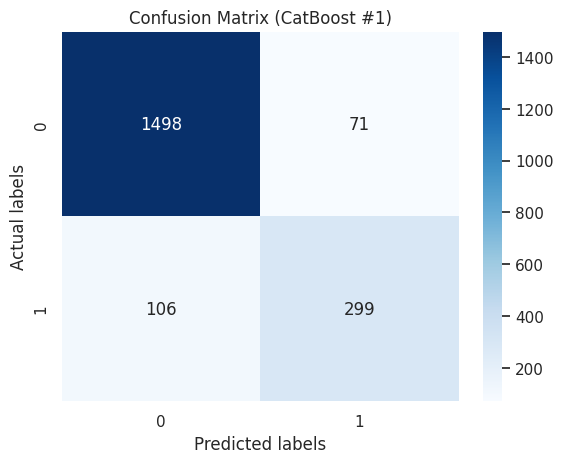

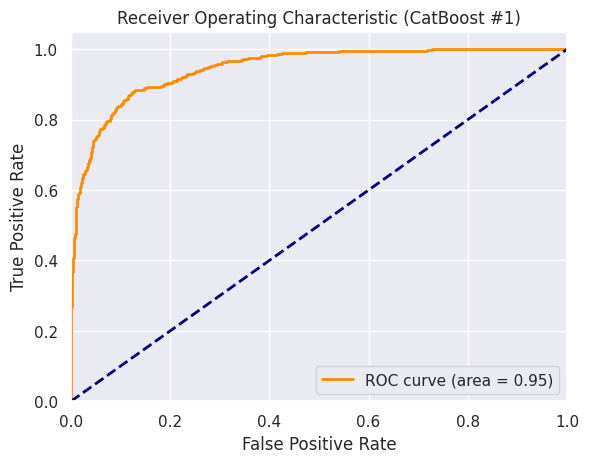

In [102]:
X_test, y_test = data_loader.get_test_data()

model = joblib.load('../models/CatBoost/model_cb.sav')
visualization.plot_roc(model, X_test, y_test, 'CatBoost #1')


## CatBoost 2

In [63]:
X_train, y_train = data_loader.get_train_data()
X_test, y_test = data_loader.get_test_data()

In [64]:
encoder = CatEncoderWrapper(columns=['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Tenure'], dtype='int64')
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [67]:
categorical_features = [1, 2]

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = X_train, X_test, y_train, y_test

def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'depth': trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-7, 1e-2, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
        'thread_count': 2,  # set the number of CPU threads to use
        'random_state': 42
    }

    # Initialize the Pool object for the training and validation data
    train_pool = Pool(X_train, y_train, cat_features=categorical_features)
    val_pool = Pool(X_val, y_val, cat_features=categorical_features)

    # Initialize the model with the hyperparameters
    model = CatBoostClassifier(**params)

    # Train the model on the training set
    model.fit(train_pool, eval_set=val_pool, verbose=False)

    # Predict the probabilities on the validation set
    y_proba = model.predict_proba(val_pool)[:, 1]

    # Calculate the AUC-ROC score
    score = roc_auc_score(y_val, y_proba)
    
    return score

# Set up the Optuna study
# study = optuna.create_study(direction='maximize',
#     storage="sqlite:///hyperparameter_tune.sqlite3",
#     study_name="catboost2")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and score
print(f'Best hyperparameters: {study.best_params}')
print(f'Best score: {study.best_value}')


[I 2023-05-28 10:02:24,065] A new study created in RDB with name: catboost2
[I 2023-05-28 10:02:31,388] Trial 0 finished with value: 0.8465846768799816 and parameters: {'learning_rate': 0.0010051067995422377, 'iterations': 620, 'depth': 7, 'l2_leaf_reg': 3.794913188541361e-05, 'border_count': 175, 'colsample_bylevel': 0.26573146499171524, 'subsample': 0.8989239121513981, 'scale_pos_weight': 2.413032527432032, 'bagging_temperature': 0.5522739666283172, 'random_strength': 2.999609932646158}. Best is trial 0 with value: 0.8465846768799816.
[I 2023-05-28 10:02:40,473] Trial 1 finished with value: 0.8523585833549716 and parameters: {'learning_rate': 0.006834469472119531, 'iterations': 979, 'depth': 6, 'l2_leaf_reg': 0.002210379300097497, 'border_count': 108, 'colsample_bylevel': 0.6926417574579369, 'subsample': 0.907566332088289, 'scale_pos_weight': 9.091221492773974, 'bagging_temperature': 6.991526653512774, 'random_strength': 9.879449869030246}. Best is trial 1 with value: 0.8523585833549

Best hyperparameters: {'bagging_temperature': 8.580570193138142, 'border_count': 141, 'colsample_bylevel': 0.9282987692994771, 'depth': 6, 'iterations': 196, 'l2_leaf_reg': 1.7158044561827527e-07, 'learning_rate': 0.09911492662583435, 'random_strength': 0.381928851094573, 'scale_pos_weight': 0.955002042974634, 'subsample': 0.7030400245940563}
Best score: 0.8697794459001171


In [68]:
encoder = CatEncoderWrapper(columns=['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Tenure'], dtype='int64')
X = encoder.transform(X)

In [70]:
with open("../models/CatBoost/best_param_enc2.json", "w") as json_file:
    json.dump(study.best_params, json_file)
    
categorical_features = [1, 2]
train_pool = Pool(X, y, cat_features=categorical_features)
model = CatBoostClassifier(**study.best_params)
model.fit(train_pool)

joblib.dump(model, '../models/CatBoost/model_cb2.sav')

0:	learn: 0.6399911	total: 32.2ms	remaining: 6.28s
1:	learn: 0.5973071	total: 58.1ms	remaining: 5.63s
2:	learn: 0.5605668	total: 77.6ms	remaining: 4.99s
3:	learn: 0.5295183	total: 106ms	remaining: 5.06s
4:	learn: 0.5041338	total: 136ms	remaining: 5.2s
5:	learn: 0.4818621	total: 141ms	remaining: 4.47s
6:	learn: 0.4629236	total: 148ms	remaining: 4s
7:	learn: 0.4465927	total: 160ms	remaining: 3.76s
8:	learn: 0.4321104	total: 173ms	remaining: 3.6s
9:	learn: 0.4201853	total: 182ms	remaining: 3.38s
10:	learn: 0.4095629	total: 191ms	remaining: 3.22s
11:	learn: 0.4008374	total: 199ms	remaining: 3.05s
12:	learn: 0.3927832	total: 206ms	remaining: 2.9s
13:	learn: 0.3855478	total: 222ms	remaining: 2.88s
14:	learn: 0.3796909	total: 227ms	remaining: 2.74s
15:	learn: 0.3748653	total: 230ms	remaining: 2.59s
16:	learn: 0.3701853	total: 234ms	remaining: 2.46s
17:	learn: 0.3659466	total: 240ms	remaining: 2.37s
18:	learn: 0.3628282	total: 245ms	remaining: 2.29s
19:	learn: 0.3591761	total: 255ms	remaining:

['../models/CatBoost/model_cb2.sav']

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1569
           1       0.84      0.59      0.69       405

    accuracy                           0.89      1974
   macro avg       0.87      0.78      0.81      1974
weighted avg       0.89      0.89      0.89      1974



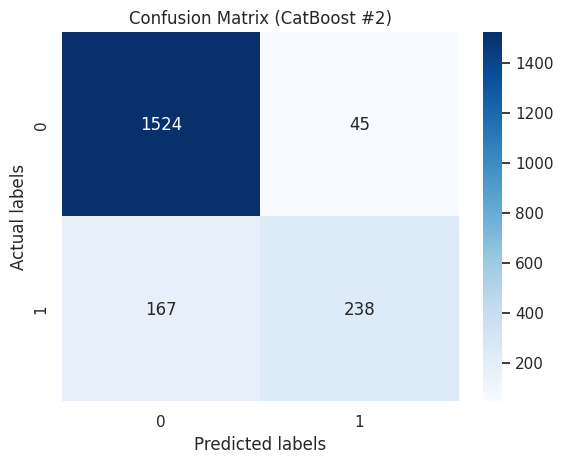

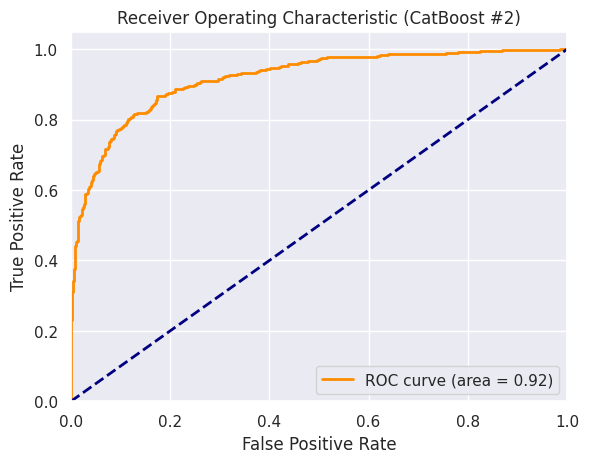

In [100]:
X_test, y_test = data_loader.get_test_data()
encoder = CatEncoderWrapper(columns=['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Tenure'], dtype='int64')
X_test = encoder.transform(X_test)

model = joblib.load('../models/CatBoost/model_cb2.sav')
visualization.plot_roc(model, X_test, y_test, 'CatBoost #2')


## CatBoost 3

In [11]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = X_train_enc, X_test_enc, y_train, y_test

def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'depth': trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-7, 1e-2, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
        'thread_count': 2,  # set the number of CPU threads to use
        'random_state': 42
    }

    # Initialize the Pool object for the training and validation data
    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)

    # Initialize the model with the hyperparameters
    model = CatBoostClassifier(**params)

    # Train the model on the training set
    model.fit(train_pool, eval_set=val_pool, verbose=False)

    # Predict the probabilities on the validation set
    y_proba = model.predict_proba(val_pool)[:, 1]

    # Calculate the AUC-ROC score
    score = roc_auc_score(y_val, y_proba)
    
    return score

#Set up the Optuna study
study = optuna.create_study(direction='maximize',
    storage="sqlite:///hyperparameter_tune.sqlite3",
    study_name="catboost3")

# study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and score
print(f'Best hyperparameters: {study.best_params}')
print(f'Best score: {study.best_value}')


[I 2023-05-28 18:57:29,107] A new study created in RDB with name: catboost3
[I 2023-05-28 18:57:33,564] Trial 0 finished with value: 0.8399546774307768 and parameters: {'learning_rate': 9.99982923711319e-05, 'iterations': 523, 'depth': 2, 'l2_leaf_reg': 3.673883136587559e-06, 'border_count': 190, 'colsample_bylevel': 0.6016492246120781, 'subsample': 0.9305905167777828, 'scale_pos_weight': 9.163136607156769, 'bagging_temperature': 8.350203555329925, 'random_strength': 9.916757907230705}. Best is trial 0 with value: 0.8399546774307768.
[I 2023-05-28 18:57:38,594] Trial 1 finished with value: 0.832493764212481 and parameters: {'learning_rate': 1.0299002490955956e-05, 'iterations': 273, 'depth': 3, 'l2_leaf_reg': 0.001600672097898994, 'border_count': 37, 'colsample_bylevel': 0.441213467025, 'subsample': 0.3748979062663993, 'scale_pos_weight': 5.975205553190663, 'bagging_temperature': 6.267985717647747, 'random_strength': 7.402192680853798}. Best is trial 0 with value: 0.8399546774307768.
[

Best hyperparameters: {'bagging_temperature': 9.600979441636884, 'border_count': 127, 'colsample_bylevel': 0.9350419125045962, 'depth': 4, 'iterations': 381, 'l2_leaf_reg': 3.3370215083363754e-07, 'learning_rate': 0.06014637915898248, 'random_strength': 0.46890618138297385, 'scale_pos_weight': 4.7163649766277045, 'subsample': 0.6027197317299016}
Best score: 0.8714082257315738


In [12]:
with open("../models/CatBoost/best_param_enc3.json", "w") as json_file:
    json.dump(study.best_params, json_file)
    
categorical_features = [1, 2]
train_pool = Pool(X_enc, y)
model = CatBoostClassifier(**study.best_params)
model.fit(train_pool)

joblib.dump(model, '../models/CatBoost/model_cb3.sav')

0:	learn: 0.6628542	total: 33.5ms	remaining: 12.7s
1:	learn: 0.6384745	total: 49.5ms	remaining: 9.37s
2:	learn: 0.6201536	total: 72.3ms	remaining: 9.11s
3:	learn: 0.6072513	total: 82.5ms	remaining: 7.78s
4:	learn: 0.5924862	total: 93.5ms	remaining: 7.03s
5:	learn: 0.5791766	total: 105ms	remaining: 6.53s
6:	learn: 0.5684147	total: 110ms	remaining: 5.87s
7:	learn: 0.5586818	total: 116ms	remaining: 5.39s
8:	learn: 0.5498608	total: 120ms	remaining: 4.94s
9:	learn: 0.5423857	total: 125ms	remaining: 4.62s
10:	learn: 0.5353768	total: 130ms	remaining: 4.38s
11:	learn: 0.5288581	total: 134ms	remaining: 4.13s
12:	learn: 0.5227103	total: 139ms	remaining: 3.94s
13:	learn: 0.5171777	total: 144ms	remaining: 3.79s
14:	learn: 0.5124021	total: 149ms	remaining: 3.64s
15:	learn: 0.5086858	total: 154ms	remaining: 3.52s
16:	learn: 0.5054717	total: 160ms	remaining: 3.43s
17:	learn: 0.5016707	total: 165ms	remaining: 3.32s
18:	learn: 0.4992942	total: 170ms	remaining: 3.25s
19:	learn: 0.4959616	total: 176ms	re

['../models/CatBoost/model_cb3.sav']

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1569
           1       0.54      0.85      0.66       405

    accuracy                           0.82      1974
   macro avg       0.75      0.83      0.77      1974
weighted avg       0.87      0.82      0.83      1974



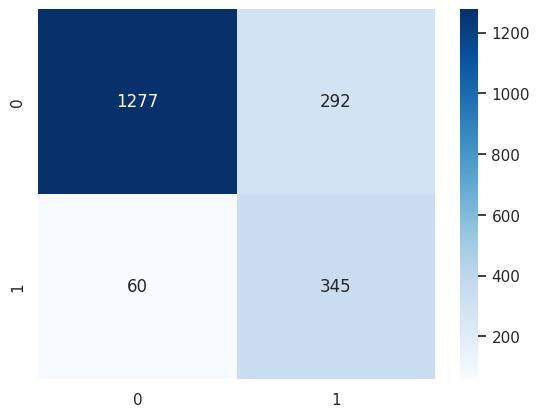

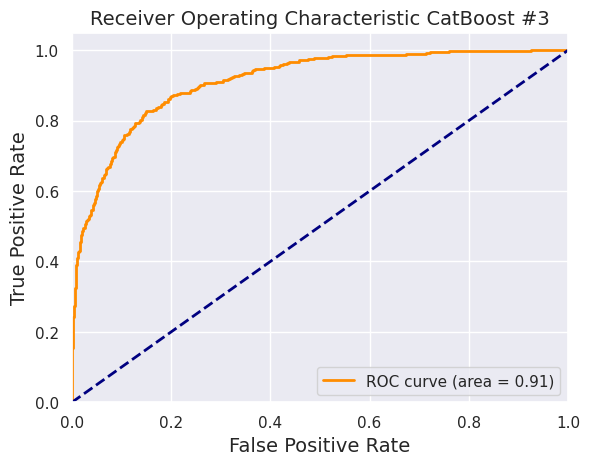

In [21]:
model = joblib.load('../models/CatBoost/model_cb3.sav')
visualization.plot_roc(model, X_test_enc, y_test_enc, 'CatBoost #3')